In [17]:
import MDAnalysis as mda
from MDAnalysis.lib import distances
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from scipy.stats import gaussian_kde
from scipy.interpolate import make_interp_spline, BSpline


# Calculate the center of mass for TRP rings
def compute_ring_coms(u, trp):
    coms = np.array([[u.atoms.select_atoms(f'(resname TRP and resid {id} and name C1 N1 C2 C3 C4 C5 C6 C7 C8)').center_of_mass()] for id in trp.residues.resids])
    return coms

# Distance between two centers of mass
def compute_distance(pos1, pos2, box_length):
    
    delta = pos1 - pos2
    
    delta_x = delta[0]
    delta_y = delta[1]
    delta_z = delta[2]
    
    delta_x -= (round(delta_x/box_length[0])) * box_length[0]
    delta_y -= (round(delta_y/box_length[1])) * box_length[1]
    delta_z -= (round(delta_z/box_length[2])) * box_length[2]
    
    return np.linalg.norm([delta_x, delta_y, delta_z])

# Angle between two vectors using dot product
def compute_angle(vec1, vec2):
    cos_theta = np.dot(vec1, vec2)
    return np.degrees(np.arccos(np.clip(cos_theta, -1, 1)))

# Cross product of two vectors
def compute_cross_product(vec1, vec2):
    return np.cross(vec1, vec2)/np.linalg.norm(np.cross(vec1, vec2))

# Vectors for C1-C4 and C1-C5 for angle calculation
def compute_vectors(trp_res):
    C1 = trp_res.atoms.select_atoms("name C1").positions[0]
    C4 = trp_res.atoms.select_atoms("name C4").positions[0]
    C5 = trp_res.atoms.select_atoms("name C5").positions[0]
    
    vector_C1_C4 = C4 - C1
    vector_C1_C5 = C5 - C1
    return vector_C1_C4, vector_C1_C5

def smooth(x, y):
    x_new = np.linspace(x.min(), x.max(), 300)
    y_smooth = make_interp_spline(x, y, k=2)
    return x_new, y_smooth(x_new)

edges = np.histogram([-1], 180, range=(0, 180))[1]
bins = 0.5 * (edges[:-1] + edges[1:])


In [45]:
u = mda.Universe("md_0_sim_resp_24trp_500ns.tpr", "md_0_sim_resp_24trp_500ns_pbc_center.xtc")
trp = u.select_atoms("resname TRP")


frac_herinbone, frac_parallel, frac_perpendicular = [], [], []
for ts in u.trajectory[5000:]:
    angles = []
    coms = compute_ring_coms(u, trp)
    n_rings = len(coms)

    for i in range(0, n_rings-1):
        for j in range(i + 1, n_rings):
            dist = compute_distance(coms[i][0], coms[j][0], u.dimensions[:3])
            # distances.append(dist)
            if dist <= 6.5:  # Distance cutoff 5.5 Å for π-π stacking
                # Vectors for the two indole rings
                vector_C1_C4_1, vector_C1_C5_1 = compute_vectors(trp.residues[i])
                vector_C1_C4_2, vector_C1_C5_2 = compute_vectors(trp.residues[j])
                
                # cross_product1 = compute_cross_product(vector_C1_C4_1, vector_C1_C4_2)
                cross_product1 = compute_cross_product(vector_C1_C4_1, vector_C1_C5_1)
                cross_product2 = compute_cross_product(vector_C1_C4_2, vector_C1_C5_2)
                
                
                # angle = compute_angle(vector_C1_C4_1, vector_C1_C4_2)
                angle = compute_angle(cross_product1, cross_product2)
                angles.append(angle)
    
    count_angle_herinbone = 0
    count_angle_parallel = 0
    count_angle_perpendicular = 0
    for i in angles:
        if 30 <= i <= 60 or 120 <= i <= 150 :
            count_angle_herinbone += 1
        elif 0 <= i <= 30 or 150 <= i <= 180 :
            count_angle_parallel += 1
        else:
            count_angle_perpendicular += 1
    frac_herinbone.append(count_angle_herinbone/len(angles) if len(angles) > 0 else 0)
    frac_parallel.append(count_angle_parallel/len(angles) if len(angles) > 0 else 0)
    frac_perpendicular.append(count_angle_perpendicular/len(angles) if len(angles) > 0 else 0)
    
print(np.mean(frac_herinbone), np.mean(frac_parallel), np.mean(frac_perpendicular))


0.4155899772426466 0.19794271304469266 0.27468966524155486


In [23]:

#TPR = 'md_0_sim_resp_24trp-1ta_500ns.tpr' 
#XTC = 'md_0_sim_resp_24trp-1ta_500ns_pbc_center.xtc'

TPR = 'md_0_sim_resp_24trp-1mnt_500ns.tpr' 
XTC = 'md_0_sim_resp_24trp-1mnt_500ns_pbc_center.xtc'

#TPR = 'md_0_sim_resp_24trp-1sbt_500ns.tpr' 
#XTC = 'md_0_sim_resp_24trp-1sbt_500ns_pbc_center.xtc'

# Load the trajectory and topology
u = mda.Universe(TPR, XTC)

# Select TRP and Tannic acids
trp = u.select_atoms("resname TRP")
ta = u.select_atoms("resname MNT")


#final_angles = []
angles_m1 = []
for ts in u.trajectory[5000:]:  
    #angles = []
    trp_coms = [trp.atoms.select_atoms(f'resid {i}').center_of_mass() for i in trp.residues.resids]
    ta_coms = ta.center_of_mass()
    #print(trp_coms, ta_coms)

    # Calculate distances from TA to all TRPs
    dist1 = [compute_distance(i, ta_coms, u.dimensions[:3]) for i in trp_coms]
    # Identify TRPs outside the cutoff (12 Å)
    cutoff_1 = 12 #12
    outside_trps_idxs = np.where(np.array(dist1) >= cutoff_1)[0]
    #print(len(outside_trps_idxs))
    coms = compute_ring_coms(u, trp)
    
    if (len(outside_trps_idxs) >= 2):
        for i in outside_trps_idxs:
            for j in outside_trps_idxs:
                if j > i:
                    dist = compute_distance(coms[i][0], coms[j][0], u.dimensions[:3])
                    # distances.append(dist)
                    if dist <= 6.5:  # Distance cutoff 5.5 Å for π-π stacking
                        # Vectors for the two indole rings
                        vector_C1_C4_1, vector_C1_C5_1 = compute_vectors(trp.residues[i])
                        vector_C1_C4_2, vector_C1_C5_2 = compute_vectors(trp.residues[j])
                
                        # cross_product1 = compute_cross_product(vector_C1_C4_1, vector_C1_C4_2)
                        cross_product1 = compute_cross_product(vector_C1_C4_1, vector_C1_C5_1)
                        cross_product2 = compute_cross_product(vector_C1_C4_2, vector_C1_C5_2)

                        # dot_product = np.dot(vector_C1_C4_1, vector_C1_C4_2)
                        # dot_product = np.dot(cross_product1, cross_product2)
                
                
                        # angle = compute_angle(vector_C1_C4_1, vector_C1_C4_2)
                        angle = compute_angle(cross_product1, cross_product2)
                        angles_m1.append(angle)
                        
    #if len(angles) > 0:
        #angle_hist = np.histogram(angles, 180, range=(0, 180))[0]
        #final_angles.append(angle_hist)

#df_angle = pd.DataFrame(final_angles)
#avg_final_angles_t1 = df_angle.mean(axis=0)

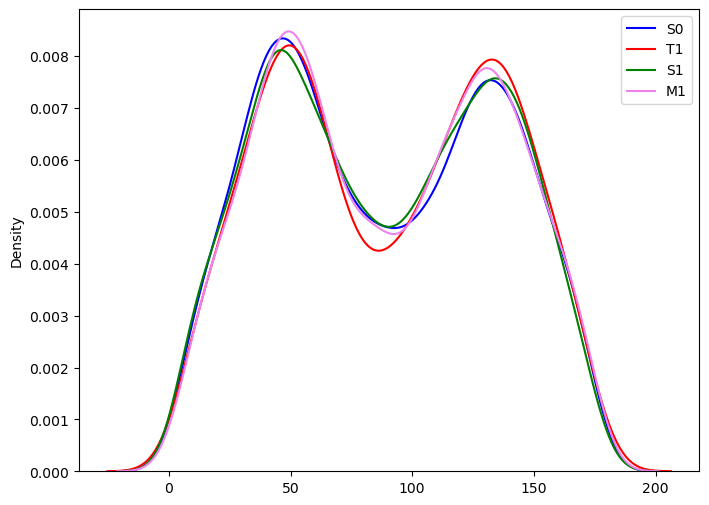

In [25]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(8, 6))
sns.kdeplot(angles_s0, color='blue', label='S0', ax=ax)
sns.kdeplot(angles_t1, color='red', label='T1', ax=ax)
sns.kdeplot(angles_s1, color='green', label='S1', ax=ax)
sns.kdeplot(angles_m1, color='violet', label='M1', ax=ax)
ax.legend()
plt.savefig('angle_histogram.png', dpi=500, bbox_inches='tight')

In [39]:
frac_angle = 0
for i in angles_m1:
    #if 30 <= i <= 60 or 120 <= i <= 150 :
    #if 0 <= i <= 30 or 150 <= i <= 180 :
    if 60 <= i <= 120:
        frac_angle += 1
frac_angle /= 276
print(frac_angle)

12.41304347826087
